# Week 12 - Linear Models (Linear Regression and Logistic Regression) 

The following is adapted from **Chapter 4 of Hands-on Machine Learning** book. Please refer to Chapter 4 of the Hands-on Machine Learning book, accessible via the link provided in the course outline.

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)



And let's create the `images/training_linear_models` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

So far we have treated machine learning models and their training algorithms mostly like black boxes. If you went through some of the exercises in the previous chapters, you may have been surprised by how much you can get done without knowing anything about what’s under the hood: you optimized a regression system, you improved a digit image classifier, and you even built a spam classifier from scratch, all without knowing how they actually work. Indeed, in many situations you don’t really need to know the implementation details.

However, having a good understanding of how things work can help you quickly home in on the appropriate model, the right training algorithm to use, and a good set of hyperparameters for your task. Understanding what’s under the hood will also help you debug issues and perform error analysis more efficiently. Lastly, most of the topics discussed in this chapter will be essential in understanding, building, and training neural networks.

In this chapter we will start by looking at the linear regression model, one of the simplest models there is. We will discuss two very different ways to train it:

- Using a “closed-form” equation⁠1 that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).

- Using an iterative optimization approach called gradient descent (GD) that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of gradient descent that we will use again and again when we study neural networks in Part II: batch GD, mini-batch GD, and stochastic GD.

Next we will look at polynomial regression, a more complex model that can fit nonlinear datasets. Since this model has more parameters than linear regression, it is more prone to overfitting the training data. We will explore how to detect whether or not this is the case using learning curves, and then we will look at several regularization techniques that can reduce the risk of overfitting the training set.

Finally, we will examine two more models that are commonly used for classification tasks: logistic regression and softmax regression.

Warning: 

There will be quite a few math equations in this chapter, using basic notions of linear algebra and calculus. To understand these equations, you will need to know what vectors and matrices are; how to transpose them, multiply them, and inverse them; and what partial derivatives are. If you are unfamiliar with these concepts, please go through the linear algebra and calculus introductory tutorials available as Jupyter notebooks in the [online supplemental material](https://github.com/ageron/handson-ml3). For those who are truly allergic to mathematics, you should still go through this chapter and simply skip the equations; hopefully, the text will be sufficient to help you understand most of the concepts.

# Linear Regression


In Chapter 1 of the book,  a simple regression model of life satisfaction was discussed:

$\text{life_satisfaction} = \theta_0 + \theta_1 \times \text{GDP_per_capita} $

This model is just a linear function of the input feature `GDP_per_capita`. $\theta_0$ and $\theta_1$ are the model’s parameters.

More generally, a linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the bias term (also called the intercept term), as shown below.

**Equation 4-1. Linear regression model prediction**

$ \hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n $

In this equation:

- $\hat{y}$ is the predicted value.
- $n$ is the number of features.
- $x_i$ is the $i$th feature value.
- $\theta_j$ is the $j$th model parameter, including the bias term $\theta_0$ and the feature weights $\theta_1, \theta_2, \cdots, \theta_n$.

This can be written much more concisely using a vectorized form, as shown in [Equation 4-2](#).



### Equation 4-2. Linear regression model prediction (vectorized form)

$
\hat{y} = h_{\theta}(\mathbf{x}) = \theta \cdot \mathbf{x}
$

In this equation:

- $h_{\theta}$ is the hypothesis function, using the model parameters $\theta$.
- $\theta$is the model’s **parameter vector**, containing the bias term $\theta_0$ and the feature weights $\theta_1$ to $\theta_n$.
- $\mathbf{x}$ is the instance’s **feature vector**, containing $x_0$ to $x_n$, with $x_0$ always equal to 1.
- $\theta \cdot \mathbf{x}$ is the dot product of the vectors $\theta$ and $\mathbf{x}$, which is equal to $\theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n$.

---

**Note:**

In machine learning, vectors are often represented as **column vectors**, which are 2D arrays with a single column. If $\theta$ and $\mathbf{x}$ are column vectors, then the prediction is $\hat{y} = \theta^T \mathbf{x}$, where $\theta^T$ is the **transpose** of $\theta$ (a row vector instead of a column vector) and $\theta^T \mathbf{x}$ is the matrix multiplication of $\theta^T$ and $\mathbf{x}$. It is of course the same prediction, except that it is now represented as a single-cell matrix rather than a scalar value. In this book I will use this notation to avoid switching between dot products and matrix multiplications.


OK, that’s the linear regression model—but how do we train it? Well, recall that training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well (or poorly) the model fits the training data. In Chapter 2 we saw that the most common performance measure of a regression model is the root mean square error. Therefore, to train a linear regression model, we need to find the value of θ that minimizes the RMSE. In practice, it is simpler to minimize the mean squared error (MSE) than the RMSE, and it leads to the same result (because the value that minimizes a positive function also minimizes its square root).

Warning: Learning algorithms will often optimize a different loss function during training than the performance measure used to evaluate the final model. This is generally because the function is easier to optimize and/or because it has extra terms needed during training only (e.g., for regularization). A good performance metric is as close as possible to the final business objective. A good training loss is easy to optimize and strongly correlated with the metric. For example, classifiers are often trained using a cost function such as the log loss (as you will see later in this chapter) but evaluated using precision/recall. The log loss is easy to minimize, and doing so will usually improve precision/recall.


The MSE of a linear regression hypothesis $ h_{\theta} $ on a training set $ X $ is calculated using the equation below.

**Equation 4-3. MSE cost function for a linear regression model**

$
\text{MSE} \left( X, h_{\theta} \right) = \frac{1}{m} \sum_{i=1}^{m} \left( \theta^T x^{(i)} - y^{(i)} \right)^2
$

Most of these notations were presented in [Chapter 2](#) (see “Notations”). The only difference is that we write $ h_{\theta} $ instead of just $ h $ to make it clear that the model is parametrized by the vector $\theta$. To simplify notations, we will just write $\text{MSE}(\theta)$ instead of $\text{MSE}(X, h_{\theta})$.

### The Normal Equation

To find the value of $\theta$ that minimizes the MSE, there exists a closed-form solution—in other words, a mathematical equation that gives the result directly. This is called the Normal equation (see below).

**Equation 4-4. Normal equation**

$
\hat{\theta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$

In this equation:

- $\hat{\theta}$ is the value of \$theta$ that minimizes the cost function.

- $\mathbf{y}$ is the vector of target values containing $ y^{(1)} $ to $ y^{(m)} $.

Let’s generate some linear-looking data to test this equation:


## The Normal Equation

In [3]:
import numpy as np

np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

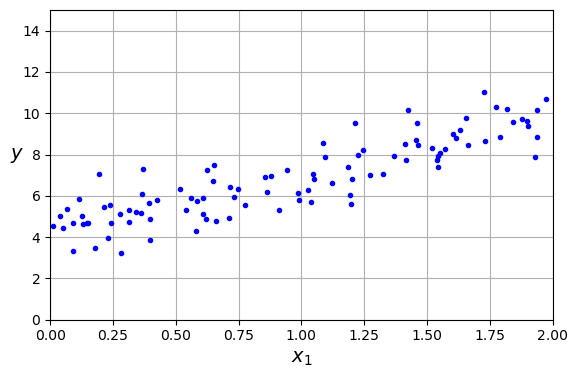

In [4]:
# extra code – generates and saves Figure 4–1

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("generated_data_plot")
plt.show()

Now let’s compute $\hat{\theta}$ using the Normal equation. We will use the `inv()` function from NumPy’s linear algebra module (`np.linalg`) to compute the inverse of a matrix, and the `dot()` method for matrix multiplication:

In [5]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

The `@` operator performs matrix multiplication. If A and B are NumPy arrays, then `A @ B` is equivalent to `np.matmul(A, B)`. Many other libraries, like TensorFlow, PyTorch, and JAX, support the `@` operator as well. However, you cannot use `@` on pure Python arrays (i.e., lists of lists).

The function that we used to generate the data is `y = 4 + 3x + Gaussian noise`. Let’s see what the equation found:

In [6]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for $θ_0$ = 4 and $θ_1 = 3$ instead of $θ_0$ = 4.215 and $θ_1$ = 2.770. Close enough, but the noise made it impossible to recover the exact parameters of the original function. The smaller and noisier the dataset, the harder it gets.

Now we can make predictions using $\hat{𝛉}$:

In [7]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions:



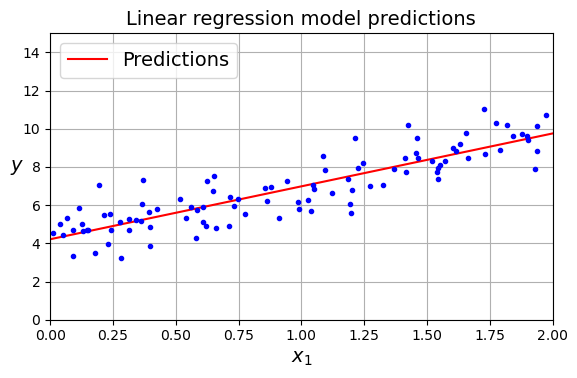

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.title("Linear regression model predictions")
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
save_fig("linear_model_predictions_plot")

plt.show()

Performing linear regression using Scikit-Learn is relatively straightforward:



In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

Notice that Scikit-Learn separates the bias term (`intercept_`) from the feature weights (`coef_`). 

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [11]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [12]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

_Advanced_: The pseudoinverse itself is computed using a standard matrix factorization technique called singular value decomposition (SVD) that can decompose the training set matrix X into the matrix multiplication of three matrices $\textbf{U}\Sigma \textbf{V}^T$ (see `numpy.linalg.svd()`). The pseudoinverse is computed as  $\mathbf{X}^{+}=\textbf{V}\Sigma^{+}\textbf{U}^T$
. To compute the matrix 
, the algorithm takes $\Sigma$ and sets to zero all values smaller than a tiny threshold value, then it replaces all the nonzero values with their inverse, and finally it transposes the resulting matrix. This approach is more efficient than computing the Normal equation, plus it handles edge cases nicely: indeed, the Normal equation may not work if the matrix $\textbf{X}^T\textbf{X}$ is not invertible (i.e., singular), such as if $m < n$ or if some features are redundant, but the pseudoinverse is always defined.

### Computational Complexity
The Normal equation computes the inverse of $\textbf{X}^T \textbf{X}$, which is an $(n + 1) × (n + 1)$ matrix (where $n$ is the number of features). The computational complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$, depending on the implementation. In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^3 = 8$. The SVD approach used by Scikit-Learn’s LinearRegression class is about $O(n^2)$. If you double the number of features, you multiply the computation time by roughly 4.



WARNING: Both the Normal equation and the SVD approach get very slow when the number of features grows large (e.g., 100,000). On the positive side, both are linear with regard to the number of instances in the training set (they are O(m)), so they handle large training sets efficiently, **provided they can fit in memory**.

Also, once you have trained your linear regression model (using the Normal equation or any other algorithm), predictions are very fast: the computational complexity is linear with regard to both the number of instances you want to make predictions on and the number of features. In other words, making predictions on twice as many instances (or twice as many features) will take roughly twice as much time.

Now we will look at a very different way to train a linear regression model, **which is better suited for cases where there are a large number of features or too many training instances to fit in memory**.



# Gradient Descent


Gradient descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of gradient descent is to tweak parameters iteratively in order to minimize a cost function.

Suppose you are lost in the mountains in a dense fog, and you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope. This is exactly what gradient descent does: it measures the local gradient of the error function with regard to the parameter vector $\mathbf{\theta}$, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

In practice, you start by filling $\mathbf{\theta}$ with random values (this is called random initialization). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.

![gradient descent](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0403.png)

In this depiction of gradient descent, the model parameters are initialized randomly and get tweaked repeatedly to minimize the cost function; the learning step size is proportional to the slope of the cost function, so the steps gradually get smaller as the cost approaches the minimum

An important parameter in gradient descent is the size of the steps, determined by the _learning rate_ hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time (see below).


![ Learning rate too small](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0404.png)


On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution


![ Learning rate too big](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0405.png)

Additionally, not all cost functions look like nice, regular bowls. There may be holes, ridges, plateaus, and all sorts of irregular terrain, making convergence to the minimum difficult. Figure below shows the two main challenges with gradient descent. If the random initialization starts the algorithm on the left, then it will converge to a local minimum, which is not as good as the global minimum. If it starts on the right, then it will take a very long time to cross the plateau. And if you stop too early, you will never reach the global minimum.

![optimality](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0406.png)


Fortunately, the MSE cost function for a linear regression model happens to be a convex function, which means that if you pick any two points on the curve, the line segment joining them is never below the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly.⁠ These two facts have a great consequence: gradient descent is guaranteed to approach arbitrarily closely the global minimum (if you wait long enough and if the learning rate is not too high).

While the cost function has the shape of a bowl, it can be an elongated bowl if the features have very different scales. Figure below shows gradient descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).⁠

![feature](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0407.png)

As you can see, on the left the gradient descent algorithm goes straight toward the minimum, thereby reaching it quickly, whereas on the right it first goes in a direction almost orthogonal to the direction of the global minimum, and it ends with a long march down an almost flat valley. It will eventually reach the minimum, but it will take a long time.

WARNING: When using gradient descent, you should ensure that all features have a similar scale (e.g., using Scikit-Learn’s `StandardScaler` class), or else it will take much longer to converge.

This diagram also illustrates the fact that training a model means searching for a combination of model parameters that minimizes a cost function (over the training set). It is a search in the model’s parameter space. The more parameters a model has, the more dimensions this space has, and the harder the search is: searching for a needle in a 300-dimensional haystack is much trickier than in 3 dimensions. Fortunately, since the cost function is convex in the case of linear regression, the needle is simply at the bottom of the bowl.

## Batch Gradient Descent

To implement gradient descent, you need to compute the gradient of the cost function with regard to each model parameter $\theta_j$. In other words, you need to calculate how much the cost function will change if you change $\theta_j$ just a little bit. This is called a partial derivative. It is like asking, “What is the slope of the mountain under my feet if I face east?” and then asking the same question facing north (and so on for all other dimensions, if you can imagine a universe with more than three dimensions). Equation below computes the partial derivative of the MSE with regard to parameter $\theta_j$, noted as $\frac{\partial \text{MSE}(\theta)}{\partial \theta_j}$.

**Equation 4-5. Partial derivatives of the cost function**

$$
\frac{\partial}{\partial \theta_j} \text{MSE}(\theta) = \frac{2}{m} \sum_{i=1}^{m} \left( \theta^T x^{(i)} - y^{(i)} \right) x_j^{(i)}
$$

Instead of computing these partial derivatives individually, you can use the equation below to compute them all in one go. The gradient vector, noted as $\nabla_\theta \text{MSE}(\theta)$, contains all the partial derivatives of the cost function (one for each model parameter).

**Equation 4-6. Gradient vector of the cost function**

$$
\nabla_\theta \text{MSE}(\theta) = 
\begin{bmatrix}
\frac{\partial}{\partial \theta_0} \text{MSE}(\theta) \\
\frac{\partial}{\partial \theta_1} \text{MSE}(\theta) \\
\vdots \\
\frac{\partial}{\partial \theta_n} \text{MSE}(\theta)
\end{bmatrix}
= \frac{2}{m} \mathbf{X}^T (\mathbf{X} \mathbf{\theta} - \mathbf{y})
$$

---

**Warning:**

Notice that this formula involves calculations over the full training set $X$, at each gradient descent step! This is why the algorithm is called **batch gradient descent**: it uses the whole batch of training data at every step (actually, **full gradient descent** would probably be a better name). As a result, it is terribly slow on very large training sets (we will look at some much faster gradient descent algorithms shortly). However, gradient descent scales well with the number of features; training a linear regression model when there are hundreds of thousands of features is much faster using gradient descent than using the Normal equation or SVD decomposition.

---

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting $\nabla_\theta \text{MSE}(\theta)$ from $\theta$. This is where the learning rate $\eta$ comes into play: multiply the gradient vector by $\eta$ to determine the size of the downhill step.

**Equation 4-7. Gradient descent step**

$$
\theta^{(\text{next step})} = \theta - \eta \nabla_\theta \text{MSE}(\theta)
$$

Let’s look at a quick implementation of this algorithm:



In [13]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

That wasn’t too hard! Each iteration over the training set is called an epoch. Let’s look at the resulting theta:

In [14]:
theta

array([[4.21509616],
       [2.77011339]])

Hey, that’s exactly what the Normal equation found! Gradient descent worked perfectly. But what if you had used a different learning rate (eta)? Figure below shows the first 20 steps of gradient descent using three different learning rates. The line at the bottom of each plot represents the random starting point, then each epoch is represented by a darker and darker line.

![Gradient descent with various learning rates](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0408.png)

On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. In the middle, the learning rate looks pretty good: in just a few epochs, it has already converged to the solution. On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.

To find a good learning rate, you can use grid search (see Chapter 2). However, you may want to limit the number of epochs so that grid search can eliminate models that take too long to converge.

You may wonder how to set the number of epochs. If it is too low, you will still be far away from the optimal solution when the algorithm stops; but if it is too high, you will waste time while the model parameters do not change anymore. A simple solution is to set a very large number of epochs but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number $\epsilon$ (called the _tolerance_)—because this happens when gradient descent has (almost) reached the minimum.

--- 
**CONVERGENCE RATE**

When the cost function is convex and its slope does not change abruptly (as is the case for the MSE cost function), batch gradient descent with a fixed learning rate will eventually converge to the optimal solution, but you may have to wait a while: it can take O(1/ϵ) iterations to reach the optimum within a range of ϵ, depending on the shape of the cost function. If you divide the tolerance by 10 to have a more precise solution, then the algorithm may have to run about 10 times longer.





## Stochastic Gradient Descent


The main problem with batch gradient descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, stochastic gradient descent picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration (stochastic GD can be implemented as an out-of-core algorithm; see Chapter 1).

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than batch gradient descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down (see Figure below). Once the algorithm stops, the final parameter values will be good, but not optimal.



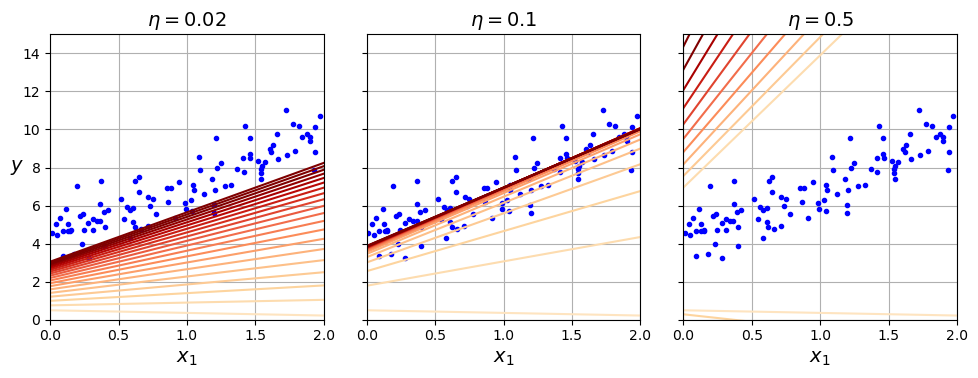

In [15]:
# extra code – generates and saves Figure 4–8

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so stochastic gradient descent has a better chance of finding the global minimum than batch gradient descent does.

Therefore, randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. This process is akin to _simulated annealing_, an algorithm inspired by the process in metallurgy of annealing, where molten metal is slowly cooled down. The function that determines the learning rate at each iteration is called the _learning schedule_. If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early.

This code implements stochastic gradient descent using a simple learning schedule:

In [16]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure

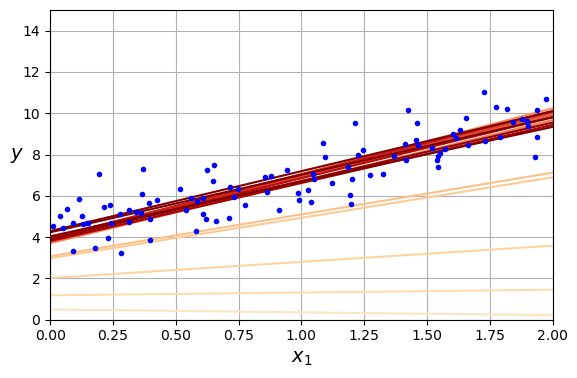

In [17]:
# The first 20 steps of stochastic gradient descent


n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("sgd_plot")
plt.show()

By convention we iterate by rounds of $m$ iterations; each round is called an **epoch**, as earlier. While the batch gradient descent code iterated 1,000 times through the whole training set, this code goes through the training set only 50 times and reaches a pretty good solution:

In [18]:
theta

array([[4.21076011],
       [2.74856079]])

The figure above shows the first 20 steps of training (notice how irregular the steps are).

Note that since instances are picked randomly, some instances may be picked several times per epoch, while others may not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set (making sure to shuffle the input features and the labels jointly), then go through it instance by instance, then shuffle it again, and so on. However, this approach is more complex, and it generally does not improve the result.

---
**WARNING**

When using stochastic gradient descent, the training instances must be independent and identically distributed (IID) to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to shuffle the instances during training (e.g., pick each instance randomly, or shuffle the training set at the beginning of each epoch). If you do not shuffle the instances—for example, if the instances are sorted by label—then SGD will start by optimizing for one label, then the next, and so on, and it will not settle close to the global minimum.

---

To perform linear regression using stochastic GD with Scikit-Learn, you can use the `SGDRegressor` class, which defaults to optimizing the MSE cost function. The following code runs for maximum 1,000 epochs (`max_iter`) or until the loss drops by less than $10^{–5}$ (`tol`) during 100 epochs (`n_iter_no_change`). It starts with a learning rate of 0.01 (`eta0`), using the default learning schedule (different from the one we used). Lastly, it does not use any regularization (`penalty=None`; more details on this shortly):

In [19]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

Once again, you find a solution quite close to the one returned by the Normal equation:

In [20]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

---
**TIP**
All Scikit-Learn estimators can be trained using the `fit()` method, but some estimators also have a `partial_fit()` method that you can call to run a single round of training on one or more instances (it ignores hyperparameters like `max_iter` or `tol`). Repeatedly calling `partial_fit()` will gradually train the model. This is useful when you need more control over the training process. Other models have a warm_start hyperparameter instead (and some have both): if you set `warm_start=True`, calling the `fit()` method on a trained model will not reset the model; it will just continue training where it left off, respecting hyperparameters like `max_iter` and `tol`. Note that `fit()` resets the iteration counter used by the learning schedule, while `partial_fit()` does not.

---

## Mini-batch gradient descent

The last gradient descent algorithm we will look at is called _mini-batch gradient descent_. It is straightforward once you know batch and stochastic gradient descent: at each step, instead of computing the gradients based on the full training set (as in batch GD) or based on just one instance (as in stochastic GD), mini-batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of mini-batch GD over stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm’s progress in parameter space is less erratic than with stochastic GD, especially with fairly large mini-batches. As a result, mini-batch GD will end up walking around a bit closer to the minimum than stochastic GD—but it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike linear regression with the MSE cost function). Figure below shows the paths taken by the three gradient descent algorithms in parameter space during training. They all end up near the minimum, but batch GD’s path actually stops at the minimum, while both stochastic GD and mini-batch GD continue to walk around. However, don’t forget that batch GD takes a lot of time to take each step, and stochastic GD and mini-batch GD would also reach the minimum if you used a good learning schedule.

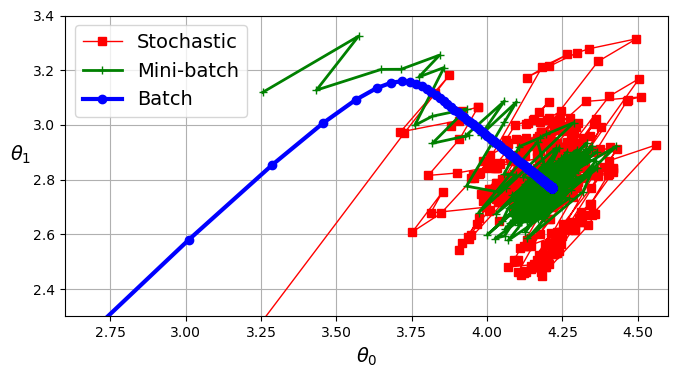

In [21]:
# extra code – this cell generates and saves Figure 4–11

from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
save_fig("gradient_descent_paths_plot")
plt.show()

The table below compares the algorithms we’ve discussed so far for linear regression⁠ (recall that $m$ is the number of training instances and $n$ is the number of features).


| Algorithm        | Large m | Out-of-core support | Large n | Hyperparams | Scaling required | Scikit-Learn       |
|------------------|---------|---------------------|---------|-------------|------------------|--------------------|
| Normal equation  | Fast    | No                  | Slow    | 0           | No               | N/A                |
| SVD              | Fast    | No                  | Slow    | 0           | No               | LinearRegression   |
| Batch GD         | Slow    | No                  | Fast    | 2           | Yes              | N/A                |
| Stochastic GD    | Fast    | Yes                 | Fast    | ≥2          | Yes              | SGDRegressor       |
| Mini-batch GD    | Fast    | Yes                 | Fast    | ≥2          | Yes              | N/A                |

There is almost no difference after training: all these algorithms end up with very similar models and make predictions in exactly the same way.


---
**Note:**

_Out-of-core support_ refers to the ability of an algorithm to handle datasets that are too large to fit into a computer's main memory (RAM). Algorithms with out-of-core support can process data incrementally, using disk storage to manage large datasets. This is important for big data applications where the dataset exceeds the available memory, enabling the algorithm to work with chunks of the data sequentially rather than loading the entire dataset into memory at once.


---






# Polynomial Regression

What if your data is more complex than a straight line? Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called polynomial regression.

Let’s look at an example. First, we’ll generate some nonlinear data (see Figure below), based on a simple quadratic equation—that’s an equation of the form $y = ax^² + bx + c$—plus some noise:

In [22]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

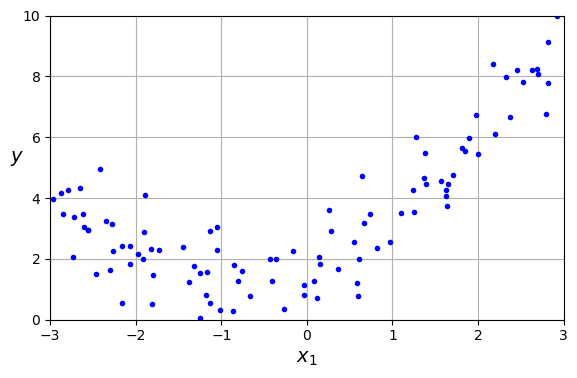

In [23]:
# extra code – this cell generates and saves Figure 4–12
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_data_plot")
plt.show()

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s `PolynomialFeatures` class to transform our training data, adding the square (second-degree polynomial) of each feature in the training set as a new feature (in this case there is just one feature):

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [25]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original feature of X plus the square of this feature. Now we can fit a `LinearRegression` model to this extended training data

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

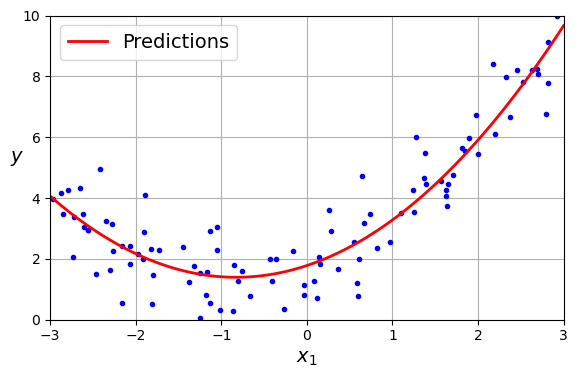

In [27]:
# extra code – this cell generates and saves Figure 4–13

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_predictions_plot")
plt.show()

Not bad: the model estimates $\hat{y} = 0.56x_1^2 + 0.93 x_1 + 1.78$ when in fact the original function was $y = 0.5 x_1^2 + 1.0x_1 + 2$ + Gaussian Noise

Note that when there are multiple features, polynomial regression is capable of finding relationships between features, which is something a plain linear regression model cannot do. This is made possible by the fact that PolynomialFeatures also adds all combinations of features up to the given degree. For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^2b$, and $ab^2$.

--- 
**Warning:**


`PolynomialFeatures(degree=d)` transforms an array containing `n` features into an array containing `(n + d)! / d!n!` features, where `n!` is the factorial of `n`, equal to `1 × 2 × 3 × ⋯ × n`. Beware of the combinatorial explosion of the number of features!

---


## Learning Curves

If you perform high-degree polynomial regression, you will likely fit the training data much better than with plain linear regression. For example, Figure 4-14 applies a 300-degree polynomial model to the preceding training data, and compares the result with a pure linear model and a quadratic model (second-degree polynomial). Notice how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.

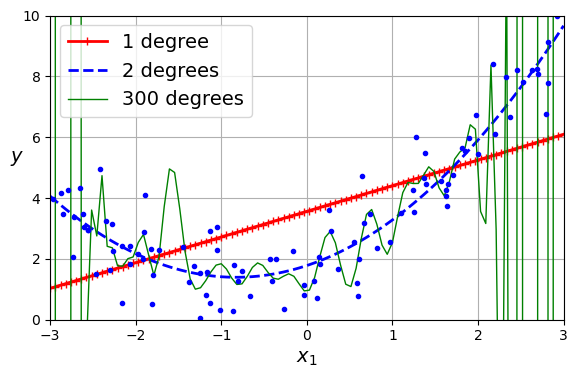

In [28]:



# extra code – this cell generates and saves Figure 4–14

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("high_degree_polynomials_plot")
plt.show()

This high-degree polynomial regression model is severely overfitting the training data, while the linear model is underfitting it. The model that will generalize best in this case is the quadratic model, which makes sense because the data was generated using a quadratic model. But in general you won’t know what function generated the data, so how can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data?

In Chapter 2 you used cross-validation to get an estimate of a model’s generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

Another way to tell is to look at the learning curves, which are plots of the model’s training error and validation error as a function of the training iteration: just evaluate the model at regular intervals during training on both the training set and the validation set, and plot the results. If the model cannot be trained incrementally (i.e., if it does not support `partial_fit()` or `warm_start`), then you must train it several times on gradually larger subsets of the training set.

Scikit-Learn has a useful `learning_curve()` function to help with this: it trains and evaluates the model using cross-validation. By default it retrains the model on growing subsets of the training set, but if the model supports incremental learning you can set `exploit_incremental_learning=True` when calling `learning_curve()` and it will train the model incrementally instead. The function returns the training set sizes at which it evaluated the model, and the training and validation scores it measured for each size and for each cross-validation fold. Let’s use this function to look at the learning curves of the plain linear regression model (see figure below):

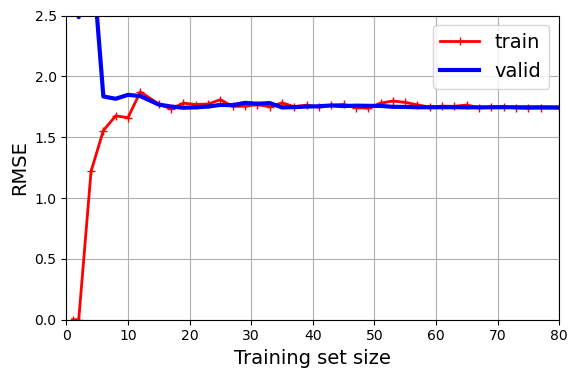

In [29]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
save_fig("underfitting_learning_curves_plot")

plt.show()

This model is underfitting. To see why, first let’s look at the training error. When there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. Now let’s look at the validation error. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite large. Then, as the model is shown more training examples, it learns, and thus the validation error slowly goes down. However, once again a straight line cannot do a good job of modeling the data, so the error ends up at a plateau, very close to the other curve.

These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.

---
**TIP**

If your model is underfitting the training data, adding more training examples will not help. You need to use a better model or come up with better features.

---

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data

In [30]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

# Learning curves for the 10th-degree polynomial model

These learning curves look a bit like the previous ones, but there are two very important differences:

- The error on the training data is much lower than before.

- There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.

--- 
**Tip:**

One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

--- 

---
**THE BIAS/VARIANCE TRADE-OFF**


An important theoretical result of statistics and machine learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

- _Bias_
    - This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.⁠6

- _Variance_
    - This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.

- _Irreducible error_
    - This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off.


---

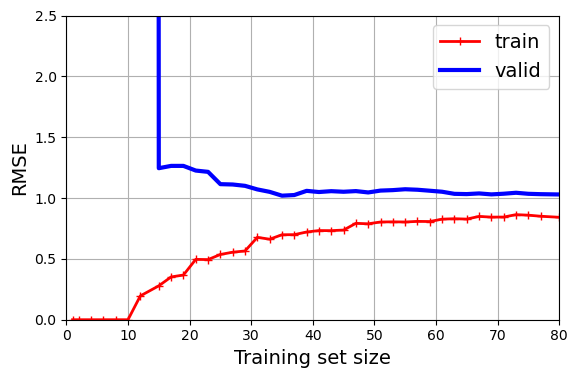

In [31]:
# extra code – generates and saves Figure 4–16

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
save_fig("learning_curves_plot")
plt.show()

# Regularized Linear Models

As you saw in Chapters 1 and 2, a good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at ridge regression, lasso regression, and elastic net regression, which implement three different ways to constrain the weights.




## Ridge Regression

**Ridge regression** (also called **Tikhonov regularization**) is a regularized version of linear regression: a regularization term equal to $\frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2$ is added to the MSE. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized MSE (or the RMSE) to evaluate the model’s performance.

The hyperparameter $\alpha$ controls how much you want to regularize the model. If $\alpha = 0$, then ridge regression is just linear regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean. Equation 4-8 presents the ridge regression cost function.

**Equation 4-8. Ridge regression cost function**

$$
J(\theta) = \textrm{MSE}(\theta) + \frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2
$$

Note that the bias term $\theta_0$ is not regularized (the sum starts at $i = 1$, not 0). If we define **w** as the vector of feature weights ($\theta_1$ to $\theta_n$), then the regularization term is equal to $\alpha ( \| w \|_2 )^2 / m$, where $\| w \|_2$ represents the $l_2$ norm of the weight vector. For batch gradient descent, just add $2\alpha w / m$ to the part of the MSE gradient vector that corresponds to the feature weights, without adding anything to the gradient of the bias term (see Equation 4-6).

> **Warning**
> 
> It is important to scale the data (e.g., using a `StandardScaler`) before performing ridge regression, as it is sensitive to the scale of the input features. This is true of most regularized models.




Let's generate a very small and noisy linear dataset:

In [32]:
# extra code – we've done this type of generation several times before
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

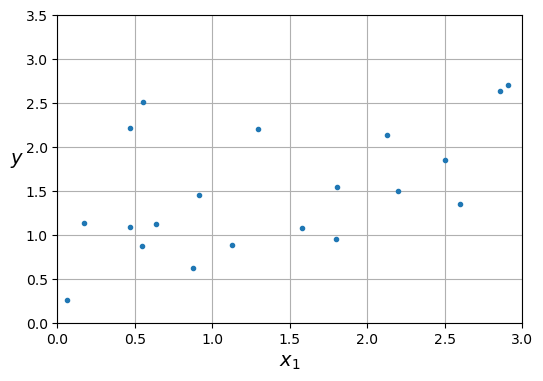

In [33]:
# extra code – a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [34]:
# Here is how to perform ridge regression with Scikit-Learn 
# using a closed-form solution (a variant of Equation 4-9 that uses 
# a matrix factorization technique by André-Louis Cholesky):

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

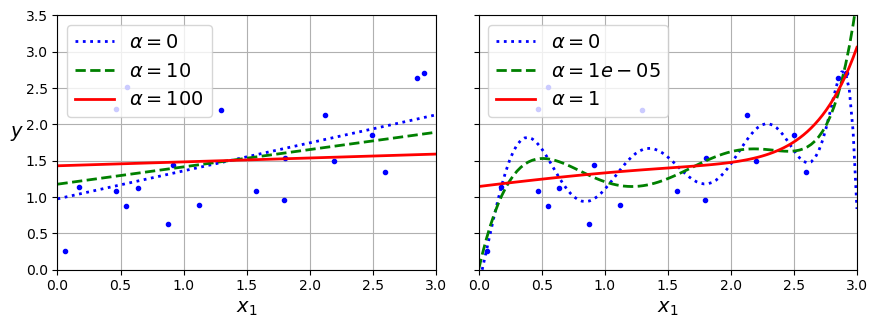

In [35]:
# extra code – this cell generates and saves Figure 4–17

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("ridge_regression_plot")
plt.show()

Figure above shows several ridge models that were trained on some very noisy linear data using different α values. On the left, plain ridge models are used, leading to linear predictions. On the right, the data is first expanded using PolynomialFeatures(degree=10), then it is scaled using a StandardScaler, and finally the ridge models are applied to the resulting features: this is polynomial regression with ridge regularization. Note how increasing α leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing the model’s variance but increasing its bias.

As with linear regression, we can perform ridge regression either by computing a closed-form equation or by performing gradient descent. The pros and cons are the same. Equation below shows the closed-form solution, where A is the $(n + 1) × (n + 1)$ identity matrix,⁠ except with a 0 in the top-left cell, corresponding to the bias term.


**Equation 4-9. Ridge regression closed-form solution**

$$
\hat{\theta} = (X^\top X + \alpha \mathbf{I})^{-1} X^\top \mathbf{y}
$$













And using stochastic gradient descent:⁠

In [36]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([1.55302613])

The penalty hyperparameter sets the type of regularization term to use. Specifying "l2" (Not 12, it's L2) indicates that you want SGD to add a regularization term to the MSE cost function equal to alpha times the square of the $l_2$ norm of the weight vector. This is just like ridge regression, except there’s no division by m in this case; that’s why we passed `alpha=0.1 / m`, to get the same result as `Ridge(alpha=0.1)`.

In [37]:
# extra code – show that we get roughly the same solution as earlier when
#              we use Stochastic Average GD (solver="sag")
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55326019]])

---
Warning:

The `RidgeCV` class also performs ridge regression, but it automatically tunes hyperparameters using cross-validation. It’s roughly equivalent to using `GridSearchCV`, but it’s optimized for ridge regression and runs much faster. Several other estimators (mostly linear) also have efficient CV variants, such as `LassoCV` and `ElasticNetCV`.

---



In [38]:
# extra code – shows the closed form solution of Ridge regression,
#              compare with the next Ridge model's learned parameters below
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

In [39]:
ridge_reg.intercept_, ridge_reg.coef_  # extra code

(array([0.97896386]), array([[0.38286422]]))

## Lasso Regression

Least absolute shrinkage and selection operator regression (usually simply called lasso regression) is another regularized version of linear regression: just like ridge regression, it adds a regularization term to the cost function, but it uses the $l_1$ norm of the weight vector instead of the square of the $l_2$ norm (see Equation 4-10). Notice that the $l_1$ norm is multiplied by 2α, whereas the $l_2$ norm was multiplied by α / m in ridge regression. These factors were chosen to ensure that the optimal α value is independent from the training set size: different norms lead to different factors (see Scikit-Learn issue #15657 for more details).

**Equation 4-10. Lasso regression cost function**

$$
J(\theta) = MSE(\theta) + 2\alpha \sum_{i=1}^{n} |\theta_i|
$$

Here is a small Scikit-Learn example using the Lasso class:

In [40]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

Note that you could instead use `SGDRegressor(penalty="l1", alpha=0.1)`.



/var/folders/ml/m1bhrv316cl9b9k8gkq8_ncm0000gn/T/ipykernel_68112/2101371668.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


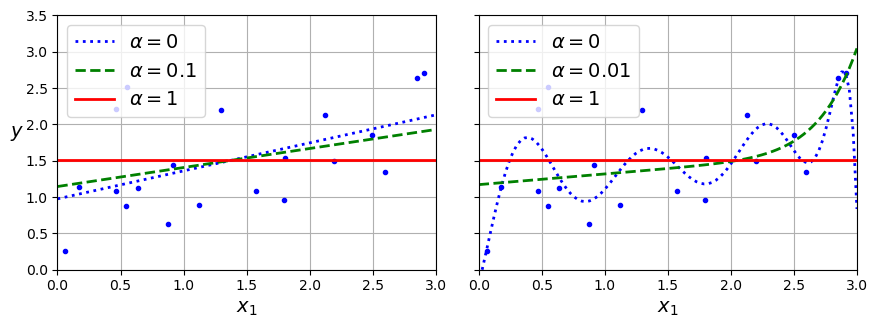

In [41]:
# extra code – this cell generates lasso model results similar to the previous figure where ridge model is demonstrated

# Linear (left) and polynomial (right) models, both using various levels of lasso regularization

plt.figure(figsize=(9, 3.5))
plt.title("Linear (left) and polynomial (right) models, both using various levels of lasso regularization")
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("lasso_regression_plot")
plt.show()

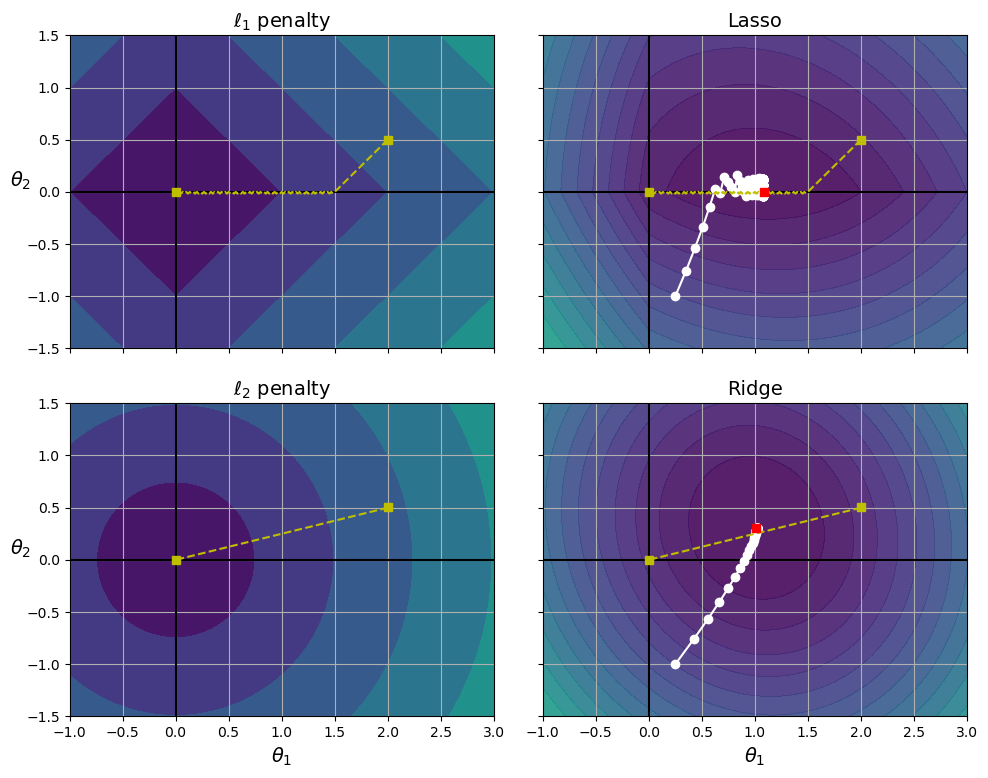

In [42]:
# extra code – this BIG cell generates and saves Figure 4–19

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

save_fig("lasso_vs_ridge_plot")
plt.show()

An important characteristic of lasso regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero). For example, the dashed line in the righthand plot in Figure above (with `α = 0.01`) looks roughly cubic: all the weights for the high-degree polynomial features are equal to zero. In other words, lasso regression automatically performs feature selection and outputs a sparse model with few nonzero feature weights.

You can get a sense of why this is the case by looking at Figure above: the axes represent two model parameters, and the background contours represent different loss functions. In the top-left plot, the contours represent the $l_1$ loss ($|\theta_1| + |\theta_2|$), which drops linearly as you get closer to any axis. For example, if you initialize the model parameters to $\theta_1$ = 2 and $\theta_2$ = 0.5, running gradient descent will decrement both parameters equally (as represented by the dashed yellow line); therefore $\theta_2$ will reach 0 first (since it was closer to 0 to begin with). After that, gradient descent will roll down the gutter until it reaches $\theta_1$ = 0 (with a bit of bouncing around, since the gradients of $l_1$ never get close to 0: they are either –1 or 1 for each parameter). In the top-right plot, the contours represent lasso regression’s cost function (i.e., an MSE cost function plus an $l_1$ loss). The small white circles show the path that gradient descent takes to optimize some model parameters that were initialized around $\theta_1$ = 0.25 and $\theta_2$ = –1: notice once again how the path quickly reaches $\theta_2$ = 0, then rolls down the gutter and ends up bouncing around the global optimum (represented by the red square). If we increased α, the global optimum would move left along the dashed yellow line, while if we decreased α, the global optimum would move right (in this example, the optimal parameters for the unregularized MSE are $\theta_1$ = 2 and $\theta_2$ = 0.5).

The two bottom plots show the same thing but with an $l_2$ penalty instead. In the bottom-left plot, you can see that the $l_2$ loss decreases as we get closer to the origin, so gradient descent just takes a straight path toward that point. In the bottom-right plot, the contours represent ridge regression’s cost function (i.e., an MSE cost function plus an $l_2$ loss). As you can see, the gradients get smaller as the parameters approach the global optimum, so gradient descent naturally slows down. This limits the bouncing around, which helps ridge converge faster than lasso regression. Also note that the optimal parameters (represented by the red square) get closer and closer to the origin when you increase $\alpha$, but they never get eliminated entirely.

--- 

**Tip**


To keep gradient descent from bouncing around the optimum at the end when using lasso regression, you need to gradually reduce the learning rate during training. It will still bounce around the optimum, but the steps will get smaller and smaller, so it will converge.


---

The lasso cost function is not differentiable at $\theta_i = 0$ (for $i = 1, 2, ⋯, n$), but gradient descent still works if you use a subgradient vector g⁠ (You can think of a subgradient vector at a nondifferentiable point as an intermediate vector between the gradient vectors around that point) instead when any $\theta_i = 0$. Equation 4-11 shows a subgradient vector equation you can use for gradient descent with the lasso cost function.

**Equation 4-11. Lasso regression subgradient vector**

$$
g(\theta, J) = \nabla MSE(\theta) + 2\alpha \begin{pmatrix}
\text{sign}(\theta_1) \\
\text{sign}(\theta_2) \\
\vdots \\
\text{sign}(\theta_n)
\end{pmatrix}
$$

where $\text{sign}(\theta_i) = \begin{cases} 
-1 & \text{if } \theta_i < 0 \\ 
0 & \text{if } \theta_i = 0 \\ 
+1 & \text{if } \theta_i > 0 
\end{cases}$

## Elastic Net

Elastic net regression is a middle ground between ridge regression and lasso regression. The regularization term is a weighted sum of both ridge and lasso’s regularization terms, and you can control the mix ratio `r`. When $r = 0$, elastic net is equivalent to ridge regression, and when $r = 1$, it is equivalent to lasso regression (Equation 4-12).

**Equation 4-12. Elastic net cost function**

$$
J(\theta) = \mathrm{MSE}(\theta) + r \left( 2\alpha \sum_{i=1}^{n} |\theta_i| \right) + (1 - r) \left( \frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2 \right)
$$



So when should you use elastic net regression, or ridge, lasso, or plain linear regression (i.e., without any regularization)? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain linear regression. Ridge is a good default, but if you suspect that only a few features are useful, you should prefer lasso or elastic net because they tend to reduce the useless features’ weights down to zero, as discussed earlier. In general, elastic net is preferred over lasso because lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

Here is a short example that uses Scikit-Learn’s ElasticNet (`l1_ratio` corresponds to the mix ratio `r`):

In [43]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

A very different way to regularize iterative learning algorithms such as gradient descent is to stop training as soon as the validation error reaches a minimum. This is called _early stopping_. Figure above shows a complex model (in this case, a high-degree polynomial regression model) being trained with batch gradient descent on the quadratic dataset we used earlier. As the epochs go by, the algorithm learns, and its prediction error (RMSE) on the training set goes down, along with its prediction error on the validation set. After a while, though, the validation error stops decreasing and starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. It is such a simple and efficient regularization technique that Geoffrey Hinton called it a “beautiful free lunch”. Below is a basic implementation of _Early Stopping_.

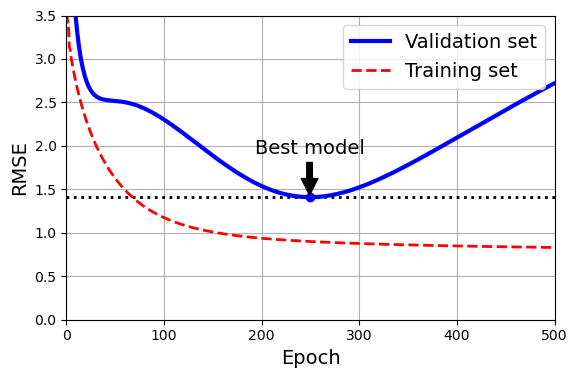

In [44]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
save_fig("early_stopping_plot")
plt.show()

This code first adds the polynomial features and scales all the input features, both for the training set and for the validation set (the code assumes that you have split the original training set into a smaller training set and a validation set). Then it creates an `SGDRegressor` model with no regularization and a small learning rate. In the training loop, it calls `partial_fit()` instead of `fit()`, to perform incremental learning. At each epoch, it measures the RMSE on the validation set. If it is lower than the lowest RMSE seen so far, it saves a copy of the model in the best_model variable. This implementation does not actually stop training, but it lets you revert to the best model after training. Note that the model is copied using `copy.deepcopy()`, because it copies both the model’s hyperparameters and the learned parameters. In contrast, `sklearn.base.clone()` only copies the model’s hyperparameters.



# Logistic Regression

As discussed in Chapter 1, some regression algorithms can be used for classification (and vice versa). Logistic regression (also called logit regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). If the estimated probability is greater than a given threshold (typically 50%), then the model predicts that the instance belongs to that class (called the _positive class_, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to the _negative class_, labeled “0”). This makes it a binary classifier.

## Estimating Probabilities

So how does logistic regression work? Just like a linear regression model, a logistic regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the linear regression model does, it outputs the logistic of this result (see Equation 4-13)

**Equation 4-13. Logistic regression model estimated probability (vectorized form)**

$$
\hat{p} = h_\theta (\mathbf{x}) = \sigma (\theta^\top \mathbf{x})
$$

The logistic—noted $\sigma(·)$ —is a sigmoid function (i.e., S-shaped) that outputs a number between 0 and 1. It is defined as shown in Equation 4-14 and Figure below.


**Equation 4-14. Logistic function**

$$
\sigma (t) = \frac{1}{1 + \exp(-t)}
$$



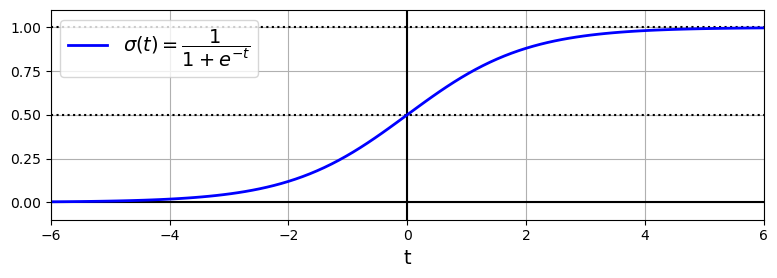

In [45]:
# extra code – generates and saves Figure 4–21

lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
save_fig("logistic_function_plot")
plt.show()

Once the logistic regression model has estimated the probability 
$\hat{p} = h_{\theta}(x)$ that an instance x belongs to the positive class, it can make its prediction $\hat{y}$ easily (see Equation 4-15).

**Equation 4-15. Logistic regression model prediction using a 50% threshold probability**

$$
\hat{y} = \begin{cases} 
0 & \text{if } \hat{p} < 0.5 \\ 
1 & \text{if } \hat{p} \ge 0.5 
\end{cases}
$$

Notice that $\sigma(t) < 0.5$ when $t < 0$, and $\sigma(t) ≥ 0.5$ when $t ≥ 0$, so a logistic regression model using the default threshold of 50% probability predicts 1 if $\mathbf{\theta}^T \mathbf{x}$ is positive and 0 if it is negative. The score t is often called the `logit`. The name comes from the fact that the logit function, defined as $logit(p) = \mathrm{log}(\frac{p}{1 – p})$, is the inverse of the logistic function. Indeed, if you compute the logit of the estimated probability $p$, you will find that the result is t. The logit is also called the _log-odds_, since it is the log of the ratio between the estimated probability for the positive class and the estimated probability for the negative class.

#### Training and Cost Function
Now you know how a logistic regression model estimates probabilities and makes predictions. But how is it trained? The objective of training is to set the parameter vector $\theta$ so that the model estimates high probabilities for positive instances ($y = 1$) and low probabilities for negative instances ($y = 0$). This idea is captured by the cost function shown in Equation 4-16 for a single training instance $x$.


**Equation 4-16. Cost function of a single training instance**

$$
c(\mathbf{\hat{y}}) = \begin{cases} 
- \log (\hat{p}) & \text{if } y = 1 \\ 
- \log (1 - \hat{p}) & \text{if } y = 0 
\end{cases}
$$

This cost function makes sense because $–\mathrm{log}(t)$ grows very large when $t$ approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be large if the model estimates a probability close to 1 for a negative instance. On the other hand, $–\mathrm{log}(t)$ is close to 0 when t is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance, which is precisely what we want.

The cost function over the whole training set is the average cost over all training instances. It can be written in a single expression called the log loss, shown in Equation 4-17.



**Equation 4-17. Logistic regression cost function (log loss)**

$J(\theta) = -\frac{1}{m} \sum_{i=1}^m [y^{(i)}\log(\hat{p}^{(i)}) + (1 - y^{(i)})\log(1-\hat{p}^{(i)})]$

---
**WARNING**

The log loss was not just pulled out of a hat. It can be shown mathematically (using Bayesian inference) that **minimizing this loss will result in the model with the maximum likelihood of being optimal, assuming that the instances follow a Gaussian distribution around the mean of their class**. When you use the log loss, this is the implicit assumption you are making. The more wrong this assumption is, the more biased the model will be. Similarly, when we used the MSE to train linear regression models, we were implicitly assuming that the data was purely linear, plus some Gaussian noise. So, if the data is not linear (e.g., if it’s quadratic) or if the noise is not Gaussian (e.g., if outliers are not exponentially rare), then the model will be biased.

--- 

The bad news is that there is no known closed-form equation to compute the value of $\theta$ that minimizes this cost function (there is no equivalent of the Normal equation). But the good news is that this cost function is convex, so gradient descent (or any other optimization algorithm) is guaranteed to find the global minimum (if the learning rate is not too large and you wait long enough). The partial derivatives of the cost function with regard to the $j^{th}$ model parameter $θ_j$ are given by Equation 4-18.


**Equation 4-18. Logistic cost function partial derivatives**

$\frac{\partial}{\partial\theta_j} J(\theta) = \frac{1}{m} \sum_{i=1}^m (\sigma(\theta^Tx^{(i)}) - y^{(i)})x_j^{(i)}$


This equation looks very much like Equation 4-5: for the $i^{th}$ training instance it computes the prediction error and multiplies it by the $j^{th}$ feature value $x_j^{(i)}$, and then it computes the average over all training instances. Once you have the gradient vector containing all the partial derivatives, you can use it in the batch gradient descent algorithm. That’s it: you now know how to train a logistic regression model. For stochastic GD you would take one instance at a time, and for mini-batch GD you would use a mini-batch at a time.

## Decision Boundaries

We can use the iris dataset to illustrate logistic regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: _Iris setosa_, _Iris versicolor_, and _Iris virginica_

![Iris](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0422.png)


Let’s try to build a classifier to detect the _Iris virginica_ type based only on the `petal width` feature. The first step is to load the data and take a quick peek:









In [46]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [47]:
print(iris.DESCR)  # extra code – it's a bit too long

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [48]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [49]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int64

In [50]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Next we’ll split the data and train a logistic regression model on the training set:



In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

Let’s look at the model’s estimated probabilities for flowers with petal widths varying from 0 cm to 3 cm:⁠

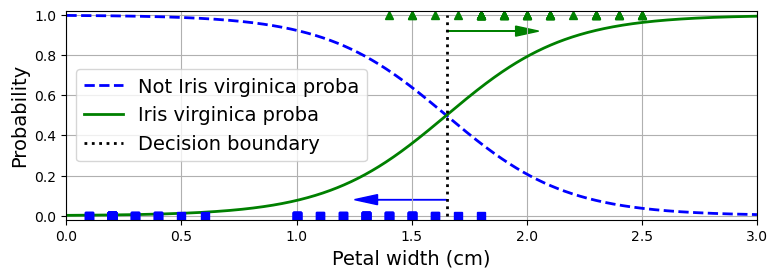

In [52]:
# Estimated probabilities and decision boundary

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies and saves Figure 4–23
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
save_fig("logistic_regression_plot")

plt.show()

The petal width of _Iris virginica_ flowers (represented as triangles) ranges from 1.4 cm to 2.5 cm, while the other _iris flowers_ (represented by squares) generally have a smaller _petal width_, ranging from 0.1 cm to 1.8 cm. Notice that there is a bit of overlap. Above about 2 cm the classifier is highly confident that the flower is an _Iris virginica_ (it outputs a high probability for that class), while below 1 cm it is highly confident that it is not an _Iris virginica_ (high probability for the “Not Iris virginica” class). In between these extremes, the classifier is unsure. However, if you ask it to predict the class (using the `predict()` method rather than the `predict_proba()` method), it will return whichever class is the most likely. Therefore, **there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%**: if the petal width is greater than 1.6 cm the classifier will predict that the flower is an _Iris virginica_, and otherwise it will predict that it is not (even if it is not very confident):

In [53]:
decision_boundary

1.6516516516516517

In [54]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

Figure below shows the same dataset, but this time displaying two features: petal `width` and `length`. Once trained, the logistic regression classifier can, based on these two features, estimate the probability that a new flower is an Iris virginica. The dashed line represents the points where the model estimates a 50% probability: this is the model’s decision boundary. Note that it is a linear boundary (It is the set of points $x$ such that $\theta_0 +\theta_1x_1 + \theta_2x_2 = 0$, which defines a straight line).⁠ Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90% (top right). All the flowers beyond the top-right line have over 90% chance of being _Iris virginica_, according to the model.

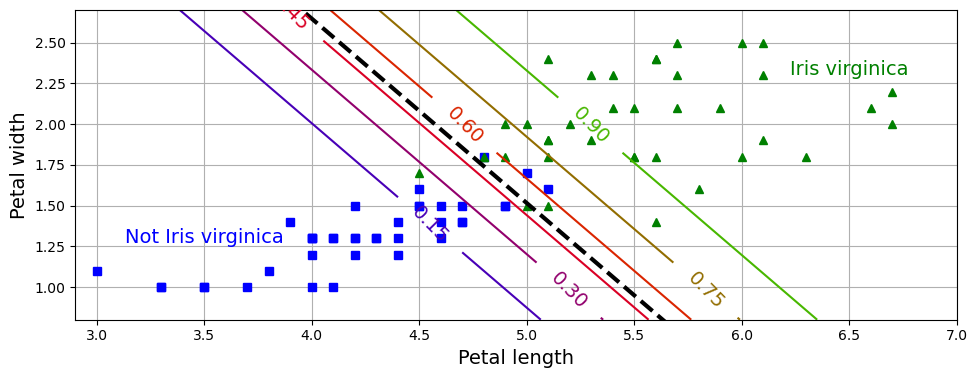

In [55]:
# extra code – this cell generates and saves Figure 4–24

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
save_fig("logistic_regression_contour_plot")
plt.show()

---
**Note**

Just like the other linear models, logistic regression models can be regularized using $l_1$ or $l_2$ penalties. Scikit-Learn actually adds an $l_2$ penalty by default.

The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is not alpha (as in other linear models), but its inverse: `C`. The higher the value of `C`, the less the model is regularized.


https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


---

## Softmax Regression

The logistic regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers (as discussed in Chapter 3). This is called `softmax regression`, or `multinomial logistic regression`.

The idea is simple: when given an instance $\mathbf{x}$, the softmax regression model first computes a score $s_{\mathbf{k}}(\mathbf{x})$ for each class $k$, then estimates the probability of each class by applying the _softmax function_ (also called the _normalized exponential_) to the scores. The equation to compute $s_{\mathbf{k}}(\mathbf{x})$ should look familiar, as it is just like the equation for linear regression prediction (see Equation 4-19).

Equation 4-19. Softmax score for class k

$s_k(\mathbf{x}) = (\theta^{(k)})^T\mathbf{x}$

Note that each class has its own dedicated parameter vector $\mathbf{θ}(k)$. All these vectors are typically stored as rows in a parameter matrix $\mathbf{\Theta}$.

Once you have computed the score of every class for the instance $\mathbf{x}$, you can estimate the probability 
 that the instance belongs to class $k$ by running the scores through the softmax function (Equation 4-20). The function computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials). The scores are generally called _logits_ or _log-odds_ (although they are actually unnormalized log-odds).
 
 

Equation 4-20. Softmax function

$\hat{p}_k = \sigma(\mathbf{s}(\mathbf{x}))_k = \frac{\exp(s_k(\mathbf{x}))}{\sum_{j=1}^K \exp(s_j(\mathbf{x}))}$

In this equation:

- $K$ is the number of classes.

- $\mathbf{s}(\mathbf{x})$ is a vector containing the scores of each class for the instance $\mathbf{x}$.

- $\sigma(\mathbf{s}(\mathbf{x}))_k$ is the estimated probability that the instance $\mathbf{x}$ belongs to class $k$, given the scores of each class for that instance.


Just like the logistic regression classifier, by default the softmax regression classifier predicts the class with the highest estimated probability (which is simply the class with the highest score), as shown in Equation 4-21.



**Equation 4-21. Softmax regression classifier prediction**

$\hat{y} = \underset{k}{\operatorname{argmax}} \sigma(\mathbf{s})_k = \underset{k}{\operatorname{argmax}} s_k(\mathbf{x}) = \underset{k}{\operatorname{argmax}} ((\theta^{(k)})^T\mathbf{x})$

The _argmax_ operator returns the value of a variable that maximizes a function. In this equation, it returns the value of $k$ that maximizes the estimated probability $\sigma(\mathbf{s}(\mathbf{x}))_k$.

---

**Tip:**

The softmax regression classifier predicts only one class at a time (i.e., it is multiclass, not multioutput), so it should be used only with mutually exclusive classes, such as different species of plants. You cannot use it to recognize multiple people in one picture.

---

Now that you know how the model estimates probabilities and makes predictions, let’s take a look at training. The objective is to have a model that estimates a high probability for the target class (and consequently a low probability for the other classes). Minimizing the cost function shown in Equation 4-22, called the `cross entropy`, should lead to this objective because it penalizes the model when it estimates a low probability for a target class. Cross entropy is frequently used to measure how well a set of estimated class probabilities matches the target classes.



**Equation 4-22. Cross entropy cost function**

$J(\theta) = -\frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K y_k^{(i)} \log(\hat{p}_k^{(i)})$


In this equation, $y_k^{(i)}$ is the target probability that the ith instance belongs to class $k$. In general, it is either equal to 1 or 0, depending on whether the instance belongs to the class or not.

Notice that when there are just two classes (K = 2), this cost function is equivalent to the logistic regression cost function (log loss; see Equation 4-17).

---


**CROSS ENTROPY:**

Cross entropy originated from Claude Shannon’s information theory. Suppose you want to efficiently transmit information about the weather every day. If there are eight options (sunny, rainy, etc.), you could encode each option using 3 bits, because $2^3 = 8$. However, if you think it will be sunny almost every day, it would be much more efficient to code “sunny” on just one bit (0) and the other seven options on four bits (starting with a 1). Cross entropy measures the average number of bits you actually send per option. If your assumption about the weather is perfect, cross entropy will be equal to the entropy of the weather itself (i.e., its intrinsic unpredictability). But if your assumption is wrong (e.g., if it rains often), cross entropy will be greater by an amount called the _Kullback–Leibler (KL) divergence_.

The cross entropy between two probability distributions p and q is defined as $H(p,q) = –\sum_{\mathbf{x}}p(x) \mathbf{log}q(x)$ (at least when the distributions are discrete). For more details, check out this [video](https://www.youtube.com/watch?v=ErfnhcEV1O8) by the book author.

The gradient vector of this cost function with regard to $\mathbf{\theta}(k)$ is given by Equation 4-23.

--- 

**Equation 4-23. Cross entropy gradient vector for class k**

$\nabla_{\theta^{(k)}} J(\mathbf{\Theta}) = \frac{1}{m} \sum_{i=1}^m (\hat{p}_k^{(i)} - y_k^{(i)})\mathbf{x}^{(i)}$

Now you can compute the gradient vector for every class, then use gradient descent (or any other optimization algorithm) to find the parameter matrix $\mathbf{\Theta}$ that minimizes the cost function.

Let’s use softmax regression to classify the iris plants into all three classes. Scikit-Learn’s `LogisticRegression` classifier uses softmax regression automatically when you train it on more than two classes (assuming you use `solver="lbfgs"`, which is the default). It also applies $l_2$ regularization by default, which you can control using the hyperparameter `C`, as mentioned earlier:




In [56]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

So the next time you find an iris with petals that are 5 cm long and 2 cm wide, you can ask your model to tell you what type of iris it is, and it will answer _Iris virginica_ (class 2) with 96% probability (or _Iris versicolor_ with 4% probability):

In [57]:
softmax_reg.predict([[5, 2]])

array([2])

In [58]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

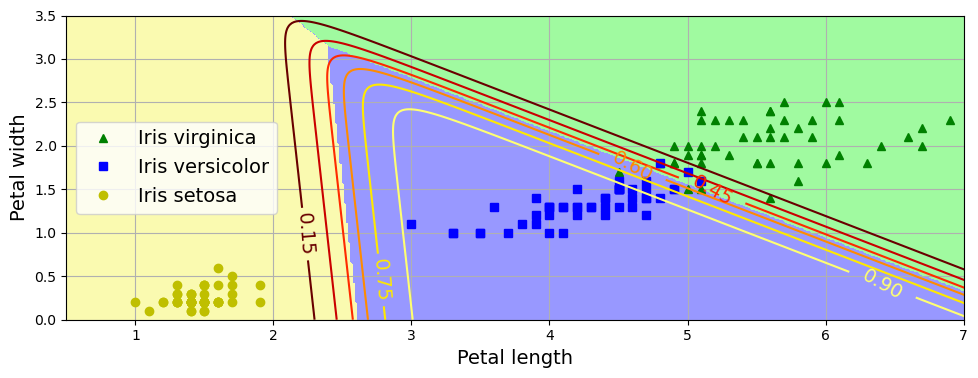

In [59]:
# extra code – this cell generates and saves Figure 4–25

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()

Figure above shows the resulting decision boundaries, represented by the background colors. Notice that the decision boundaries between any two classes are linear. The figure also shows the probabilities for the _Iris versicolor class_, represented by the curved lines (e.g., the line labeled with 0.30 represents the 30% probability boundary). Notice that the model can predict a class that has an estimated probability below 50%. For example, at the point where all decision boundaries meet, all classes have an equal estimated probability of 33%.

In this chapter, you learned various ways to train linear models, both for regression and for classification. You used a closed-form equation to solve linear regression, as well as gradient descent, and you learned how various penalties can be added to the cost function during training to regularize the model. Along the way, you also learned how to plot learning curves and analyze them, and how to implement early stopping. Finally, you learned how logistic regression and softmax regression work. We’ve opened up the first machine learning black boxes! In the next chapters we will open many more, starting with support vector machines.